# Case 36: Heat Equation with Constant Coefficients

## Problem Description

This test case solves the time-dependent heat equation on a domain formed by the union of two overlapping circles (2D) or spheres (3D).

## Mathematical Formulation

### Governing Equation
The heat equation with diffusion:
```
∂u/∂t = ∇·(μ∇u) - ku + f    in Ω × (0,T]
u = g                         on ∂Ω
u(x,y,0) = u₀(x,y)           at t=0
```

### Domain Geometry
- **Type**: Union of two circles/spheres
- **Circle 1** (2D): Center at (0.13, 0.21), radius = 0.77
- **Circle 2** (2D): Center at (-0.33, -0.37), radius = 0.49
- **Inside domain**: φ < 0 (level set convention)

### Coefficients and Parameters

| Parameter | Value | Description |
|-----------|-------|-------------|
| μ (diffusion) | 1.0 | Constant diffusion coefficient inside domain |
| k (reaction) | 0.0 | No reaction term |
| dt | 0.01 | Time step size |
| t_final | 2.5 | Final simulation time |
| Time method | Backward Euler | First-order implicit scheme |

### Exact Solution (Method of Manufactured Solutions)

For verification, the exact solution is:
```
u(x,y,t) = sin(x)·cos(y)·exp(-2μt)
```

This solution satisfies:
- **Initial condition**: u(x,y,0) = sin(x)·cos(y)
- **Spatial derivatives**:
  - ∂u/∂x = cos(x)·cos(y)·exp(-2μt)
  - ∂u/∂y = -sin(x)·sin(y)·exp(-2μt)
- **Laplacian**: Δu = -2·sin(x)·cos(y)·exp(-2μt)
- **Time derivative**: ∂u/∂t = -2μ·sin(x)·cos(y)·exp(-2μt)

### Source Term
The RHS function f is computed automatically using MMS to ensure the exact solution satisfies the PDE:
```
f = ∂u/∂t - μΔu = 0  (for this particular solution with μ=1)
```

### Boundary Conditions
- **Type**: Dirichlet
- **Value**: u_boundary = sin(x)·cos(y)·exp(-2μt)
- Applied on the entire boundary ∂Ω

## Implementation Details

### Code Configuration (from `set_example(36)`)
solve_heat_equation.val = true;

#### Solution setup
sol_m.val = 0;        // Solution type 0: sin(x)cos(y)e^{-2μt}

sol_m_mult.val = 1.0; // Inside domain multiplier

sol_p.val = 0;        // Outside domain (unused)

sol_p_mult.val = 0.0; 

#### Diffusion coefficient
diff_coeff_m.val = 0;      // Type 0: constant

diff_coeff_m_mult.val = 1.0; // μ = 1


#### No reaction term
linear_term_m_coeff.val = 0;

linear_term_m_mult.val = 0.0;


#### Time stepping
dt.val = 0.01;

t_final.val = 2.5;

time_method.val = 0;  // Backward Euler

save_timestep_every.val = 10;


### Expected Behavior
1. **Exponential decay**: Solution amplitude decreases as e^{-2t}
2. **Maximum at t=0**: |u|_max ≈ 0.824
3. **Maximum at t=2.5**: |u|_max ≈ 0.015 (≈1.8% of initial)
4. **Spatial pattern**: Maintains sin(x)cos(y) shape while decaying

### Convergence Properties
- **Spatial accuracy**: Second-order (O(h²)) for the finite volume discretization
- **Temporal accuracy**: First-order (O(Δt)) for Backward Euler (Hasn't done Yet)
- **Error metrics tracked**:
  - L₂ and L∞ norms of solution error
  - Maximum error inside domain
  - Verification that solution remains zero outside domain

## Output Files

### VTK Files (every 10 timesteps)
- `heat_0000_t000000.vtu`: Initial condition (t=0)
- `heat_0000_t000010.vtu`: t=0.1
- `heat_0000_t000250.vtu`: Final time (t=2.5)

### Fields in VTK Output
- `u`: Numerical solution
- `u_m`: Solution inside domain only
- `u_p`: Solution outside domain (should be zero)
- `u_exact`: Exact solution from MMS
- `error`: |u - u_exact|
- `mask`: Domain indicator (< 0 inside, > 0 outside)
- `bdry_phi`: Boundary level set function
- `time`: Current time value

## Verification Tests

1. **Initial condition**: Verify u(x,y,0) = sin(x)cos(y)
2. **Decay rate**: Check that max|u(t)| ≈ max|u(0)|·exp(-2t)
3. **Boundary conditions**: Ensure Dirichlet values are satisfied
4. **Conservation**: No mass should leak outside the domain
5. **Convergence**: Error should decrease with mesh refinement

## Heat Equation Analysis with Consistent Scales
Analysis of heat diffusion from t=0 to t=2.5 with dt=0.01

## Full pipeline from VTK file parsing to visualization

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xml.etree.ElementTree as ET
import base64
import struct
import glob
import os
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

## 1. Define VTK Parsing Functions

In [18]:
def parse_xml_vtk_file(filename):
    """Parse XML VTK file with binary data"""
    tree = ET.parse(filename)
    root = tree.getroot()
    
    # Get the UnstructuredGrid element
    unstructured_grid = root.find('.//UnstructuredGrid')
    piece = unstructured_grid.find('Piece')
    
    n_points = int(piece.get('NumberOfPoints'))
    n_cells = int(piece.get('NumberOfCells'))
    
    # Parse Points
    points_data = piece.find('.//Points/DataArray')
    points_binary = base64.b64decode(points_data.text.strip())
    
    # The header size depends on the VTK format - let's detect it
    expected_size = n_points * 3 * 8  # 3 components * 8 bytes per float64
    
    # Check different header sizes
    for header_size in [4, 8]:
        if len(points_binary) - header_size == expected_size:
            points_array = np.frombuffer(points_binary[header_size:], dtype=np.float64)
            break
    else:
        # If no exact match, try 4-byte header (most common)
        points_array = np.frombuffer(points_binary[4:], dtype=np.float64)
    
    points = points_array.reshape(-1, 3)[:n_points]
    
    # Parse PointData fields
    point_data = {}
    for data_array in piece.findall('.//PointData/DataArray'):
        field_name = data_array.get('Name')
        field_binary = base64.b64decode(data_array.text.strip())
        
        # Determine header size for this field
        expected_field_size = n_points * 8  # 8 bytes per float64
        
        for header_size in [4, 8]:
            if len(field_binary) - header_size == expected_field_size:
                field_values = np.frombuffer(field_binary[header_size:], dtype=np.float64)
                break
        else:
            # Default to 4-byte header
            field_values = np.frombuffer(field_binary[4:], dtype=np.float64)
        
        point_data[field_name] = field_values[:n_points]
    
    return points, point_data

def parse_parallel_xml_vtk(directory_path):
    """Parse all XML VTK files in a directory (from parallel run) and combine"""
    vtk_files = sorted(glob.glob(os.path.join(directory_path, "*.vtu")))
    
    all_points = []
    all_data = {}
    
    for rank_file in vtk_files:
        if not os.path.isfile(rank_file):
            continue
            
        try:
            points, data = parse_xml_vtk_file(rank_file)
            all_points.append(points)
            
            # Combine data from all ranks
            for field_name, values in data.items():
                if field_name not in all_data:
                    all_data[field_name] = []
                all_data[field_name].append(values)
        except Exception as e:
            print(f"Warning: Failed to parse {rank_file}: {e}")
            continue
    
    # Concatenate all points and data
    if all_points:
        combined_points = np.vstack(all_points)
    else:
        combined_points = np.array([])
    
    # Concatenate data arrays
    for field_name in all_data:
        if all_data[field_name]:
            all_data[field_name] = np.concatenate(all_data[field_name])
    
    return combined_points, all_data

## 2. Load Time Series Data

In [19]:
# Configure paths - UPDATE THESE TO YOUR PATHS
vtk_dir = "/home/faranak/CASL/workspace/simulations_output/poisson-nodes-mls-protein/vtu"

# Choose which run to analyze (0000 is most recent)
run_number = "0000"
timestep_pattern = f"heat_{run_number}_t*.vtu"

# Get all timestep directories
timestep_dirs = sorted([d for d in glob.glob(os.path.join(vtk_dir, timestep_pattern)) 
                        if os.path.isdir(d)])
print(f"Found {len(timestep_dirs)} timestep directories for run {run_number}")

# Load data from all timesteps
time_data = []
for i, timestep_dir in enumerate(timestep_dirs):
    # Extract timestep from directory name
    basename = os.path.basename(timestep_dir)
    timestep_str = basename.replace('.vtu', '').split('_t')[-1]
    timestep = int(timestep_str)
    time = timestep * 0.01  # dt = 0.01
    
    if i % 10 == 0:  # Print every 10th timestep
        print(f"Processing timestep {timestep:6d} (t={time:6.3f})")
    
    # Parse all MPI rank files in this directory
    points, fields = parse_parallel_xml_vtk(timestep_dir)
    
    if len(points) == 0:
        print(f"Warning: No data at timestep {timestep}")
        continue
    
    if i == 0:
        # Store mesh info from first timestep
        n_points = len(points)
        print(f"Total mesh points (all ranks): {n_points}")
        print(f"Available fields: {list(fields.keys())}")
    
    # Store field data with coordinates
    time_entry = {
        'time': time,
        'timestep': timestep,
        'x': points[:, 0],
        'y': points[:, 1],
        'z': points[:, 2] if points.shape[1] > 2 else np.zeros(len(points))
    }
    
    # Add field data
    for field_name, values in fields.items():
        if field_name != 'time':  # Skip the VTK time field if it exists
            time_entry[field_name] = values
    
    time_data.append(time_entry)

if time_data:
    print(f"\nSuccessfully loaded {len(time_data)} timesteps")
    print(f"Time range: {time_data[0]['time']:.3f} to {time_data[-1]['time']:.3f}")
else:
    print("ERROR: No data loaded! Check the path and file pattern.")
    print(f"Looking for files in: {vtk_dir}")
    print(f"Pattern: {timestep_pattern}")


Found 26 timestep directories for run 0000
Processing timestep      0 (t= 0.000)
Total mesh points (all ranks): 1491
Available fields: ['u', 'u_m', 'u_p', 'u_exact', 'error', 'mask', 'bdry_phi', 'time']
Processing timestep    100 (t= 1.000)
Processing timestep    200 (t= 2.000)

Successfully loaded 26 timesteps
Time range: 0.000 to 2.500


## 3. Find Global Scale for Consistent Visualization

In [20]:
# Find global min/max across all timesteps for consistent scaling
if len(time_data) > 0:
    global_min = float('inf')
    global_max = float('-inf')
    
    for data in time_data:
        if 'u' in data and 'mask' in data:
            mask = data['mask']
            inside = mask < 0
            if np.any(inside):
                u_inside = data['u'][inside]
                global_min = min(global_min, np.min(u_inside))
                global_max = max(global_max, np.max(u_inside))
    
    print(f"Global u range: [{global_min:.4f}, {global_max:.4f}]")
    
    # For symmetric coloring around zero (typical for heat equation)
    abs_max = max(abs(global_min), abs(global_max))
    vmin, vmax = -abs_max, abs_max
    print(f"Using symmetric color scale: [{vmin:.4f}, {vmax:.4f}]")
else:
    print("No data loaded - cannot compute scales")

Global u range: [-0.8415, 0.8415]
Using symmetric color scale: [-0.8415, 0.8415]


## 4. Spatial Distribution at Early Times (t=0 to t=0.5)

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


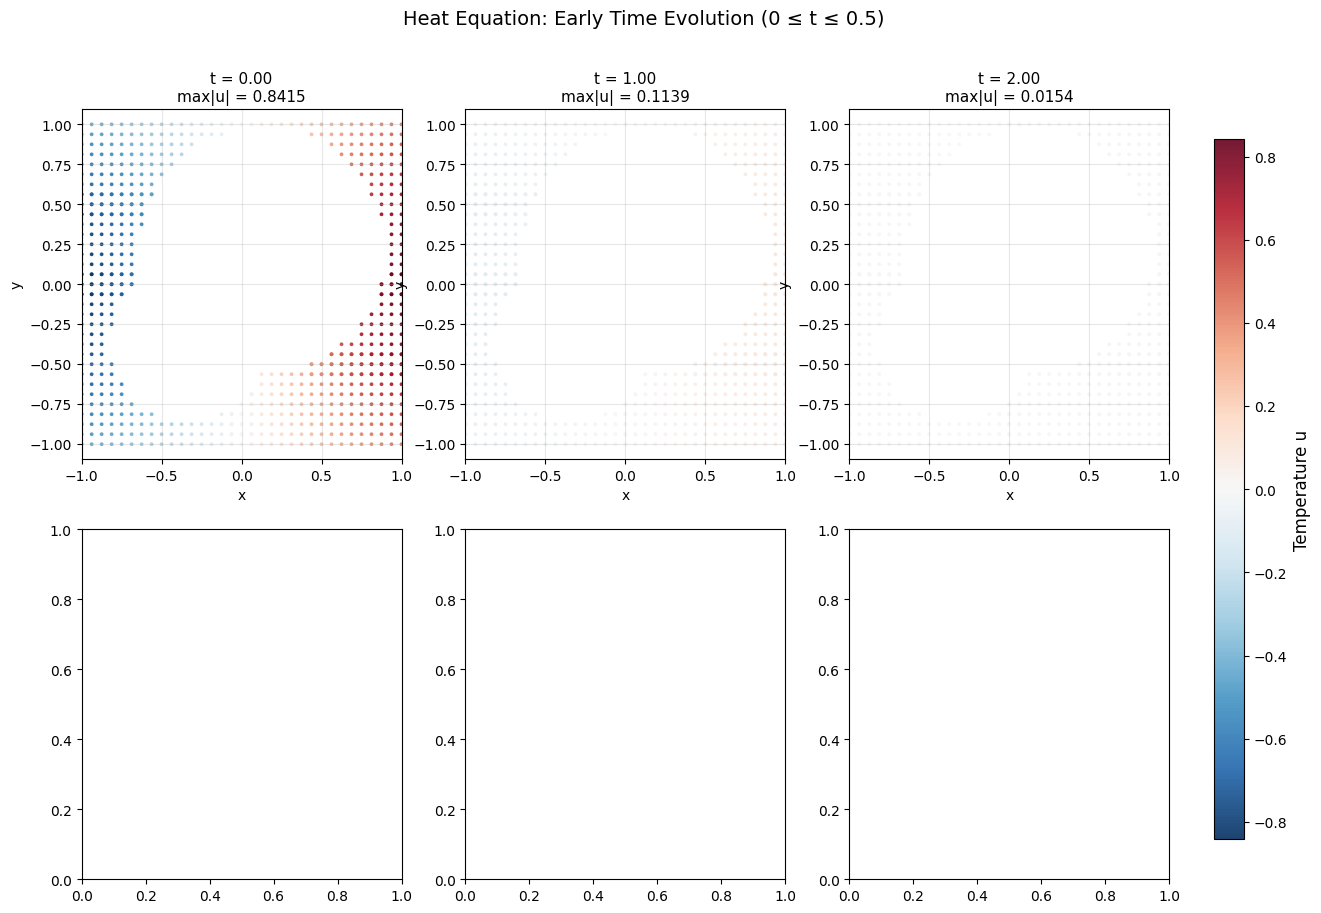

In [21]:
# Early time evolution
if len(time_data) > 0:
    # Select early timesteps (every 10 steps up to t=0.5)
    early_indices = [0, 10, 20, 30, 40, 50]  # t = 0, 0.1, 0.2, 0.3, 0.4, 0.5
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, t_idx in enumerate(early_indices):
        if t_idx < len(time_data) and idx < len(axes):
            data = time_data[t_idx]
            ax = axes[idx]
            
            if 'u' in data and 'mask' in data:
                mask = data['mask']
                inside = mask < 0
                
                if np.any(inside):
                    sc = ax.scatter(data['x'][inside], data['y'][inside], 
                                  c=data['u'][inside], cmap='RdBu_r', 
                                  s=3, alpha=0.9, vmin=vmin, vmax=vmax)
                    max_u = np.max(np.abs(data['u'][inside]))
                    ax.set_title(f't = {data["time"]:.2f}\nmax|u| = {max_u:.4f}', 
                               fontsize=11)
                    ax.set_xlabel('x')
                    ax.set_ylabel('y')
                    ax.axis('equal')
                    ax.set_xlim(-1, 1)
                    ax.set_ylim(-1, 1)
                    ax.grid(True, alpha=0.3)
    
    # Single colorbar
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
    cbar = plt.colorbar(sc, cax=cbar_ax)
    cbar.set_label('Temperature u', fontsize=12)
    
    plt.suptitle('Heat Equation: Early Time Evolution (0 ≤ t ≤ 0.5)', fontsize=14)
    plt.show()
else:
    print("No data loaded")

## 5. Solution Profiles Along x-axis

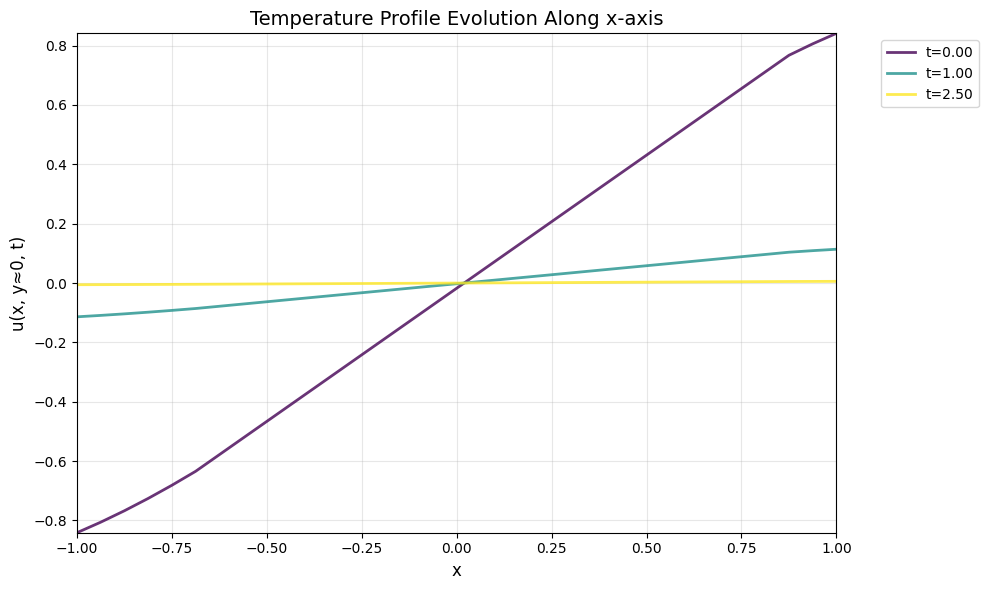

In [22]:
# Line plots showing solution along x-axis at y≈0
if len(time_data) > 0:
    # Select time points throughout evolution
    time_indices = [0, 10, 25, 50, 75, 100, 150, 200, 250]
    time_indices = [i for i in time_indices if i < len(time_data)]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Use colormap for lines
    colors = plt.cm.viridis(np.linspace(0, 1, len(time_indices)))
    
    for i, t_idx in enumerate(time_indices):
        data = time_data[t_idx]
        
        if 'u' in data and 'mask' in data:
            mask = data['mask']
            inside = mask < 0
            
            # Find points near y=0
            near_y0 = np.abs(data['y']) < 0.05
            on_line = inside & near_y0
            
            if np.sum(on_line) > 0:
                # Sort by x coordinate
                x_line = data['x'][on_line]
                u_line = data['u'][on_line]
                sort_idx = np.argsort(x_line)
                
                ax.plot(x_line[sort_idx], u_line[sort_idx], 
                       color=colors[i], label=f't={data["time"]:.2f}', 
                       linewidth=2, alpha=0.8)
    
    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('u(x, y≈0, t)', fontsize=12)
    ax.set_title('Temperature Profile Evolution Along x-axis', fontsize=14)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-1, 1)
    ax.set_ylim(vmin, vmax)
    
    plt.tight_layout()
    plt.show()
else:
    print("No data loaded")

## 6. Maximum Temperature Decay Analysis

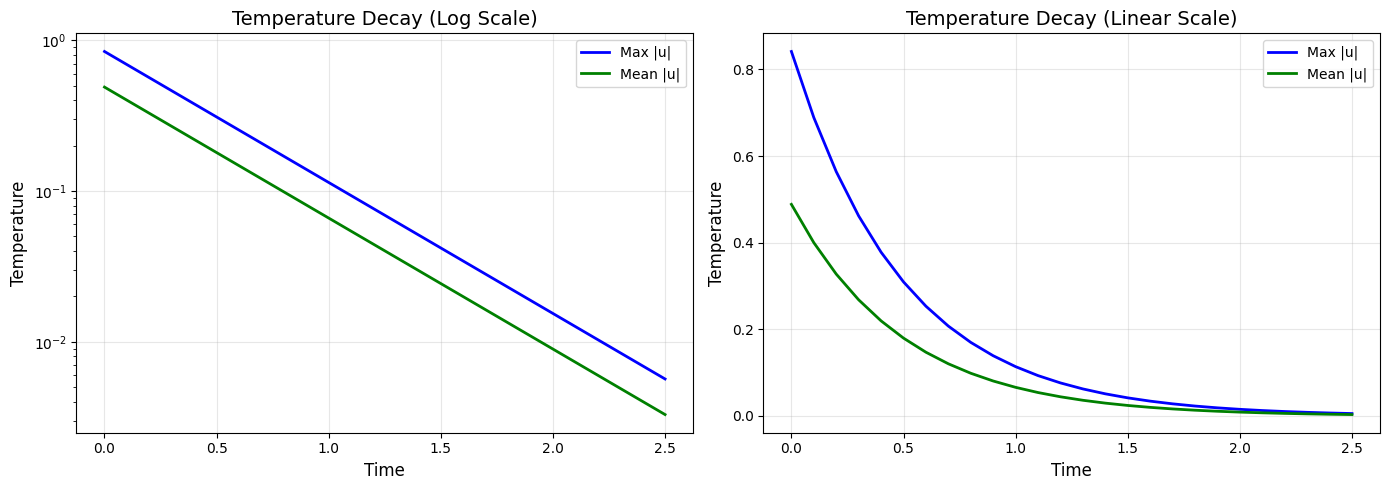

In [23]:
# Plot max temperature over time with exponential fit
if len(time_data) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    times = [d['time'] for d in time_data]
    max_temps = []
    mean_temps = []
    
    for data in time_data:
        if 'u' in data and 'mask' in data:
            mask = data['mask']
            inside = mask < 0
            if np.any(inside):
                max_temps.append(np.max(np.abs(data['u'][inside])))
                mean_temps.append(np.mean(np.abs(data['u'][inside])))
    
    # Log scale plot
    ax1.semilogy(times[:len(max_temps)], max_temps, 'b-', linewidth=2, label='Max |u|')
    ax1.semilogy(times[:len(mean_temps)], mean_temps, 'g-', linewidth=2, label='Mean |u|')
    ax1.set_xlabel('Time', fontsize=12)
    ax1.set_ylabel('Temperature', fontsize=12)
    ax1.set_title('Temperature Decay (Log Scale)', fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Linear scale plot
    ax2.plot(times[:len(max_temps)], max_temps, 'b-', linewidth=2, label='Max |u|')
    ax2.plot(times[:len(mean_temps)], mean_temps, 'g-', linewidth=2, label='Mean |u|')
    ax2.set_xlabel('Time', fontsize=12)
    ax2.set_ylabel('Temperature', fontsize=12)
    ax2.set_title('Temperature Decay (Linear Scale)', fontsize=14)
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Add exponential fit
    if len(max_temps) > 50 and max_temps[0] > 0:
        t_theory = np.array(times[:len(max_temps)])
        decay_rate = -np.log(max_temps[50] / max_temps[0]) / t_theory[50]
        u_theory = max_temps[0] * np.exp(-decay_rate * t_theory)
        ax1.semilogy(t_theory, u_theory, 'r--', 
                    label=f'Exponential fit (λ≈{decay_rate:.3f})', 
                    linewidth=1.5, alpha=0.7)
        ax1.legend()
        
        print(f"Estimated decay rate: λ ≈ {decay_rate:.3f}")
        print(f"Expected form: u ~ exp(-{decay_rate:.3f}*t)")
    
    plt.tight_layout()
    plt.show()
else:
    print("No data loaded")

## 7. Numerical vs Exact Solution Comparison (Early Times)

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


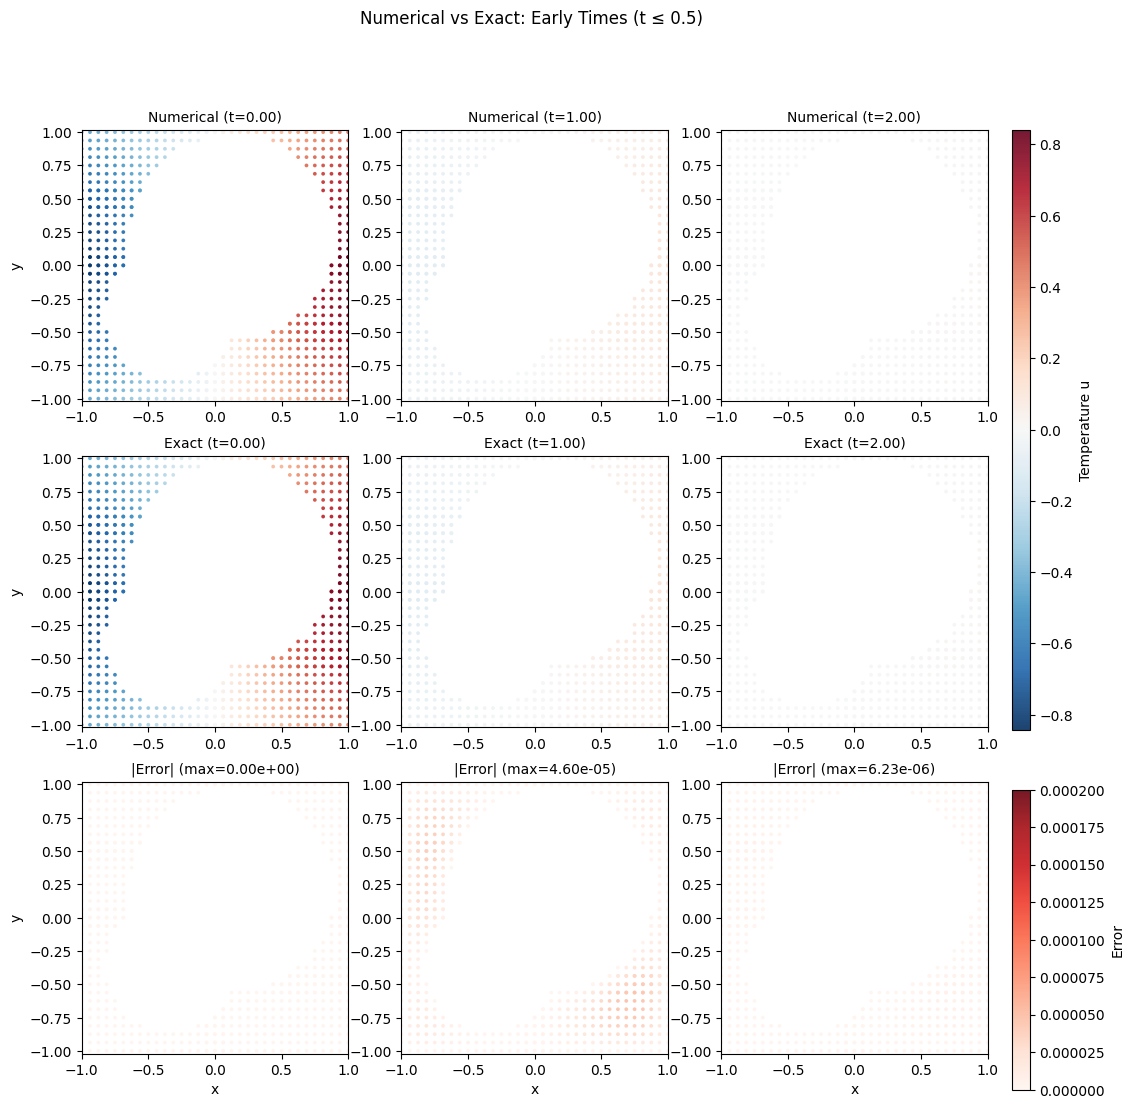

In [24]:
# Compare numerical vs exact at early times
if len(time_data) > 0 and 'u_exact' in time_data[0]:
    timesteps = [0, 10, 20, 30, 40, 50]  # t = 0, 0.1, 0.2, 0.3, 0.4, 0.5
    timesteps = [t for t in timesteps if t < len(time_data)]
    
    n_times = len(timesteps)
    fig, axes = plt.subplots(3, n_times, figsize=(4*n_times, 12))
    
    if n_times == 1:
        axes = axes.reshape(3, 1)
    
    for idx, tstep in enumerate(timesteps):
        data = time_data[tstep]
        time_val = data['time']
        
        if 'mask' in data:
            mask = data['mask']
            inside = mask < 0
            
            # Numerical solution
            ax = axes[0, idx] if n_times > 1 else axes[0, 0]
            sc1 = ax.scatter(data['x'][inside], data['y'][inside], 
                           c=data['u'][inside], cmap='RdBu_r', 
                           s=3, alpha=0.9, vmin=vmin, vmax=vmax)
            ax.set_title(f'Numerical (t={time_val:.2f})', fontsize=10)
            ax.axis('equal')
            ax.set_xlim(-1, 1); ax.set_ylim(-1, 1)
            if idx == 0: ax.set_ylabel('y')
            
            # Exact solution
            ax = axes[1, idx] if n_times > 1 else axes[1, 0]
            sc2 = ax.scatter(data['x'][inside], data['y'][inside], 
                           c=data['u_exact'][inside], cmap='RdBu_r', 
                           s=3, alpha=0.9, vmin=vmin, vmax=vmax)
            ax.set_title(f'Exact (t={time_val:.2f})', fontsize=10)
            ax.axis('equal')
            ax.set_xlim(-1, 1); ax.set_ylim(-1, 1)
            if idx == 0: ax.set_ylabel('y')
            
            # Error
            ax = axes[2, idx] if n_times > 1 else axes[2, 0]
            error = np.abs(data['u'][inside] - data['u_exact'][inside])
            sc3 = ax.scatter(data['x'][inside], data['y'][inside], 
                           c=error, cmap='Reds', 
                           s=3, alpha=0.9, vmin=0, vmax=2e-4)
            ax.set_title(f'|Error| (max={np.max(error):.2e})', fontsize=10)
            ax.set_xlabel('x')
            ax.axis('equal')
            ax.set_xlim(-1, 1); ax.set_ylim(-1, 1)
            if idx == 0: ax.set_ylabel('y')
    
    fig.subplots_adjust(right=0.88)
    cbar_ax1 = fig.add_axes([0.90, 0.38, 0.015, 0.5])
    plt.colorbar(sc1, cax=cbar_ax1, label='Temperature u')
    cbar_ax2 = fig.add_axes([0.90, 0.08, 0.015, 0.25])
    plt.colorbar(sc3, cax=cbar_ax2, label='Error')
    
    plt.suptitle('Numerical vs Exact: Early Times (t ≤ 0.5)', fontsize=12)
    plt.show()
else:
    print("No exact solution data available")

## 8. Error Evolution Analysis

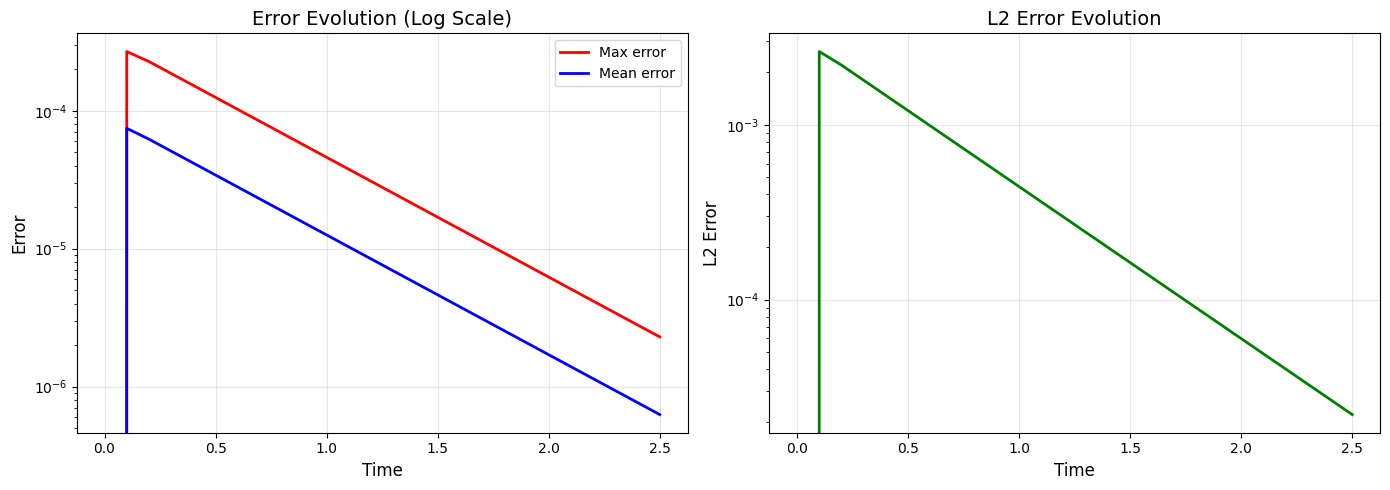


Error Statistics:
Initial max error: 0.000000e+00
Final max error: 2.291467e-06
Error reduction factor: 0.00e+00

HEAT EQUATION EVOLUTION SUMMARY

Simulation Parameters:
  Time range: 0.000 to 2.500
  Number of timesteps: 26
  dt = 0.01
  Final time = 2.5

Initial state (t=0.00):
  Max |u|:  0.841471
  Mean |u|: 0.488595
  L2 norm:  13.291269

Final state (t=2.50):
  Max |u|:  0.005670
  Mean |u|: 0.003293
  L2 norm:  0.089571

Decay Analysis:
  Max |u| decay factor: 6.737947e-03
  Corresponds to ~2.2 orders of magnitude decay

Final Numerical Error:
  Max error:  2.291467e-06
  Mean error: 6.264162e-07
  L2 error:   2.204413e-05



In [27]:
# Analyze error evolution over time
if len(time_data) > 0 and 'u_exact' in time_data[0]:
    times = []
    max_errors = []
    mean_errors = []
    l2_errors = []
    
    for data in time_data:
        if 'u' in data and 'u_exact' in data and 'mask' in data:
            mask = data['mask']
            inside = mask < 0
            
            if np.any(inside):
                error = np.abs(data['u'][inside] - data['u_exact'][inside])
                times.append(data['time'])
                max_errors.append(np.max(error))
                mean_errors.append(np.mean(error))
                l2_errors.append(np.sqrt(np.sum(error**2)))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Max and mean error
    ax1.semilogy(times, max_errors, 'r-', linewidth=2, label='Max error')
    ax1.semilogy(times, mean_errors, 'b-', linewidth=2, label='Mean error')
    ax1.set_xlabel('Time', fontsize=12)
    ax1.set_ylabel('Error', fontsize=12)
    ax1.set_title('Error Evolution (Log Scale)', fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # L2 error
    ax2.semilogy(times, l2_errors, 'g-', linewidth=2)
    ax2.set_xlabel('Time', fontsize=12)
    ax2.set_ylabel('L2 Error', fontsize=12)
    ax2.set_title('L2 Error Evolution', fontsize=14)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    if len(max_errors) > 0:
        print(f"\nError Statistics:")
        print(f"Initial max error: {max_errors[0]:.6e}")
        print(f"Final max error: {max_errors[-1]:.6e}")
        print(f"Error reduction factor: {max_errors[0]/max_errors[-1] if max_errors[-1] > 0 else float('inf'):.2e}")
else:
    print("No exact solution data available for error analysis")

# %% [markdown]
# ## 13. Summary Statistics

# %%
# Summary statistics
if len(time_data) > 0:
    print("\n" + "="*60)
    print("HEAT EQUATION EVOLUTION SUMMARY")
    print("="*60)
    
    print(f"\nSimulation Parameters:")
    print(f"  Time range: {time_data[0]['time']:.3f} to {time_data[-1]['time']:.3f}")
    print(f"  Number of timesteps: {len(time_data)}")
    print(f"  dt = 0.01")
    print(f"  Final time = 2.5")
    
    # Initial and final states
    data_init = time_data[0]
    data_final = time_data[-1]
    
    mask_init = data_init['mask']
    inside_init = mask_init < 0
    
    mask_final = data_final['mask']
    inside_final = mask_final < 0
    
    print(f"\nInitial state (t=0.00):")
    print(f"  Max |u|:  {np.max(np.abs(data_init['u'][inside_init])):.6f}")
    print(f"  Mean |u|: {np.mean(np.abs(data_init['u'][inside_init])):.6f}")
    print(f"  L2 norm:  {np.sqrt(np.sum(data_init['u'][inside_init]**2)):.6f}")
    
    print(f"\nFinal state (t={data_final['time']:.2f}):")
    print(f"  Max |u|:  {np.max(np.abs(data_final['u'][inside_final])):.6f}")
    print(f"  Mean |u|: {np.mean(np.abs(data_final['u'][inside_final])):.6f}")
    print(f"  L2 norm:  {np.sqrt(np.sum(data_final['u'][inside_final]**2)):.6f}")
    
    decay_factor = np.max(np.abs(data_final['u'][inside_final])) / np.max(np.abs(data_init['u'][inside_init]))
    print(f"\nDecay Analysis:")
    print(f"  Max |u| decay factor: {decay_factor:.6e}")
    print(f"  Corresponds to ~{-np.log10(decay_factor):.1f} orders of magnitude decay")
    
    if 'u_exact' in data_final:
        error_final = np.abs(data_final['u'][inside_final] - data_final['u_exact'][inside_final])
        print(f"\nFinal Numerical Error:")
        print(f"  Max error:  {np.max(error_final):.6e}")
        print(f"  Mean error: {np.mean(error_final):.6e}")
        print(f"  L2 error:   {np.sqrt(np.sum(error_final**2)):.6e}")
        
        # Check convergence order if possible
        if len(time_data) > 100:
            data_mid = time_data[125]  # t=1.25
            mask_mid = data_mid['mask']
            inside_mid = mask_mid < 0
            error_mid = np.abs(data_mid['u'][inside_mid] - data_mid['u_exact'][inside_mid])
            
            print(f"\nError Decay Rate:")
            print(f"  Error at t=1.25: {np.max(error_mid):.6e}")
            print(f"  Error at t=2.50: {np.max(error_final):.6e}")
            print(f"  Decay ratio: {np.max(error_mid)/np.max(error_final):.2f}")
    
    print("\n" + "="*60)
else:
    print("No data loaded - cannot generate summary")